In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import r2_score

In [51]:
# Load data
data = pd.read_csv(r"D:\Tan's data\testModel\FPT.csv", index_col='Date/Time', parse_dates=True)
data = data[['Close']]
data

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [60]:
train = pd.DataFrame(data[0:int(len(data)*0.90)])
test = pd.DataFrame(data[int(len(data)*0.90): int(len(data))])

print(train.shape)
print(test.shape)

(87665, 1)
(9741, 1)


In [61]:
scaler = MinMaxScaler(feature_range=(0,1))

In [65]:
data_training_array = scaler.fit_transform(train)
data_training_array

array([[0.02717622],
       [0.02377919],
       [0.02080679],
       ...,
       [0.97027601],
       [0.96602972],
       [0.97027601]])

In [66]:
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [68]:
x_train.shape

(87565, 100, 1)

In [78]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mse', metrics = ['MAE'])

# Train the model
model.fit(x_train, y_train, epochs = 2, batch_size = 32)


Epoch 1/2


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2737/2737 ━━━━━━━━━━━━━━━━━━━━ 501s 180ms/step - MAE: 0.0746 - loss: 0.0143
Epoch 2/2
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 509s 186ms/step - MAE: 0.0318 - loss: 0.0018


In [79]:
past_100_days = pd.DataFrame(train[-100:])
test_df = pd.DataFrame(test)
final_df = pd.concat([past_100_days, test_df], ignore_index=True)
final_df.head()


,Close
0,53.2
1,53.3
2,53.3
3,53.3
4,53.3


In [80]:
input_data = scaler.transform(final_df)
input_data

array([[0.36585366],
       [0.37804878],
       [0.37804878],
       ...,
       [0.97560976],
       [0.96341463],
       [0.96341463]])

In [81]:
input_data.shape

(9841, 1)

In [82]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(9741, 100, 1)
(9741,)


In [84]:
# Make predictions
y_predict = model.predict(x_test)

305/305 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step


In [85]:
scaler.scale_

array([0.12195122])

In [87]:
scale_factor = 1/0.12195122
y_predict = y_predict * scale_factor
y_test = y_test * scale_factor

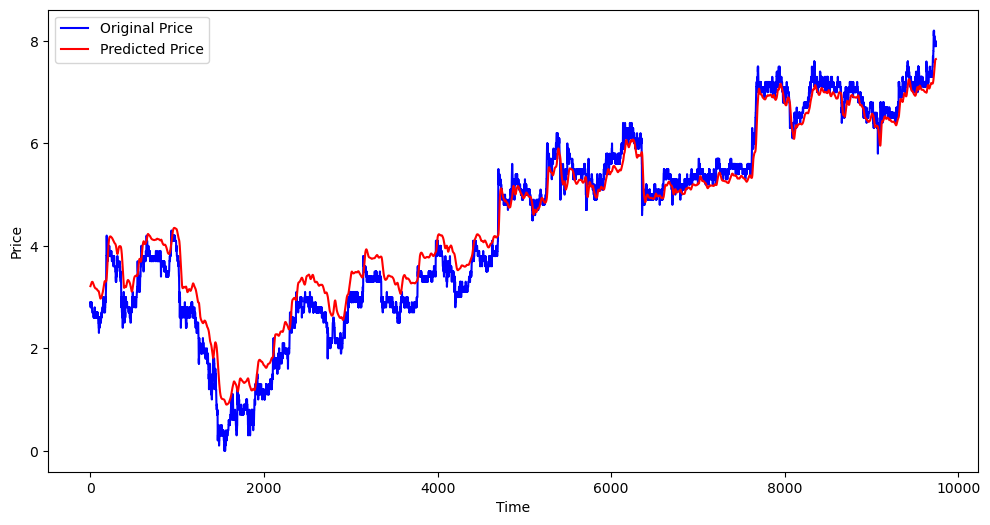

In [89]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_predict, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [90]:
print("R2: {}".format(r2_score(y_test, y_predict)))

R2: 0.9592520769574091
